In [14]:
import pandas as pd
from pathlib import Path
from loader import get_subfolders, load_multiple_timings

folders = get_subfolders(Path("../measurements/with_shuffle/nlpkkt200"))
# Returns the matrix name and a dictionary of mapping from function to dataframe
matrix, ft = load_multiple_timings(folders)

In [12]:
ft['comb']

,nodes,mpi,func,duration,bytes
0,256,256,gemm,2.623460e+09,0.0
1,256,256,gemm,2.710980e+09,0.0
2,256,256,gemm,2.614280e+09,0.0
3,256,256,gemm,2.699960e+09,0.0
4,256,256,gemm,2.659280e+09,0.0
...,...,...,...,...,...
46,256,256,bytes,0.000000e+00,0.0
47,256,256,bytes,0.000000e+00,0.0
48,256,256,bytes,0.000000e+00,0.0
49,256,256,bytes,0.000000e+00,0.0


In [13]:
ft['drop_at_once_parallel']

,func,duration,bytes,nodes,mpi
0,triplets_to_map,7.699780e+09,0,16,16
1,triplets_to_map,5.853000e+09,0,16,16
2,triplets_to_map,3.181540e+09,0,16,16
3,triplets_to_map,4.430060e+09,0,16,16
0,shuffle,3.600950e+11,0,16,16
...,...,...,...,...,...
125,build_csr,6.066050e+05,0,512,512
126,build_csr,6.808490e+05,0,512,512
127,build_csr,8.037230e+05,0,512,512
128,build_csr,1.098390e+06,0,512,512


In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

SCALING_FACTOR = 10**9
plt.rcParams['font.family'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
STYLES = {
    # color, marker, offst, name
    "comb": ('dodgerblue', 'D', (-80, -40), "\\textsc{CombBLAS}", None),
    "drop_at_once_parallel": ('deeppink', 'o', (-50, -20), "\\textsc{DropAtOnceNS}", None),
    "todo2": ('goldenrod', 'h', (-60, -20), "\\textsc{NHWC}", None),
    "todo3": ('brown', '^', (-210, -135), "\\textsc{Tensor Macro}", 26),
    "todo4": ('darkcyan', 'H', (-75, -15), "\\textsc{Merged}", None),
    "todo5": ('darkolivegreen', 's', (-120, -118), "\\textsc{Merged+Blocked}", None),
}

0    256
Name: nodes, dtype: int64 0    2.739812
Name: avg, dtype: float64
0     16
1     32
2     64
3    128
4    256
5    512
Name: nodes, dtype: int64 0    0.424798
1    0.579554
2    1.089154
3    0.983832
4    0.540728
5    0.939754
Name: avg, dtype: float64


/nix/store/j7551yn2pmn9zd59lhsmczbxqv3f68d2-python3.11-matplotlib-3.8.4/lib/python3.11/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/tmp/ipykernel_806422/176444080.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(nodes, values, yerr=eb, fmt='-o', label=algo, marker=marker, color=color)


Text(0.5, 1.0, 'DIOCANE: nlpkkt200')

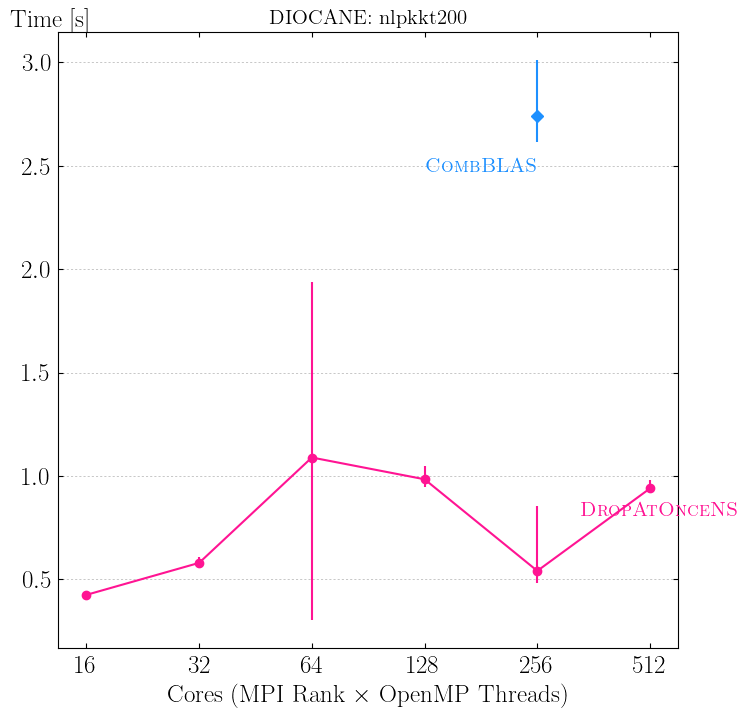

In [36]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

for algo, pretty_name in (('comb', 'ComBLAS'), ('drop_at_once_parallel', 'Our')):
    timings = ft[algo]
    func_data = timings[timings["func"] == 'gemm']

    timings = []
    for key, group in func_data.groupby("nodes"):
        value = group["duration"]
        timings.append({
            "nodes": key,
            "avg": value.mean()/SCALING_FACTOR,
            "min": value.min()/SCALING_FACTOR,
            "max": value.max()/SCALING_FACTOR
        })

    timings = pd.DataFrame(timings)
    # Calculate the error bars
    eb = [
        (timings['avg'] - timings['min']),
        (timings['max'] - timings['avg'])
    ]

    color, marker, offst, name, rotation = STYLES[algo]

    nodes = timings["nodes"]
    values = timings["avg"]
    ax.annotate(name, (nodes.iloc[-1], values.iloc[-1]), color=color, xytext=offst, textcoords='offset points', fontsize='x-large', rotation=rotation or 0)
    ax.errorbar(nodes, values, yerr=eb, fmt='-o', label=algo, marker=marker, color=color)

    ax.set_xlabel("Cores (MPI Rank $\\times$ OpenMP Threads)")
    ax.set_ylabel('Time [s]',
            rotation='horizontal',
            loc='top',
            labelpad=-50)

ax.tick_params(axis='both', direction='in', which='major', pad=5)
ax.grid(which='major', axis='y', linewidth=.5, dashes=(3,3))
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter(ScalarFormatter())

ax.set_title(f"DIOCANE: {matrix}", fontsize=15)